## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Heurísticas LPT+ y EDD+ para asignación de quirófanos

#### Autor: Jesús García Armario

In [33]:
# Imports
import numpy as np
import pandas as pd
from Utils import ActoQuirurgico, Quirofano
import matplotlib.pyplot as plt

In [34]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)

In [35]:
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]

In [36]:
# Creamos un set de actos quirúrgicos
actos_pendientes = set()
i = 0
for elemento in df.itertuples():
    actos_pendientes.add(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1


In [37]:
# División protegida
def protectedDivision(dividend, divisor):
    if divisor == 0:
        return dividend
    else:
        return dividend / divisor

In [38]:
print ("Número de actos quirúrgicos: ", len(actos_pendientes))
def ordenaPacientesLPT(actos_pendientes : set):
    # Calculamos los deciles de la ponderación
    deciles = np.percentile([acto.getPrioridad() for acto in actos_pendientes], np.arange(0, 100, 10))
    # Creamos un diccionario con los deciles y los pacientes que pertenecen a cada uno
    diccionario = {}
    for i in range(len(deciles)):
        diccionario[i] = set()
    for acto in actos_pendientes:
        for i in range(len(deciles)-1):
            if acto.getPrioridad() >= deciles[i] and acto.getPrioridad() < deciles[i+1]:
                diccionario[i].add(acto)
                break
            # Si estamos en el último decil, incluimos todos los pacientes que tengan una ponderación mayor o igual
            # al último decil
            if i == len(deciles)-2:
                diccionario[i+1].add(acto)
                break
    # Ordenamos los pacientes de cada decil por duración de mayor a menor
    for i in range(len(deciles)):
        diccionario[i] = sorted(diccionario[i], key=lambda acto: acto.getDuracion(), reverse=True)
    # Creamos una lista con los pacientes ordenados de mayor decil a menor
    actos_ordenados = []
    for i in range(len(diccionario)-1, -1, -1):
        actos_ordenados += diccionario[i]
    return actos_ordenados

def ordenaPacientesLPTEDD(actos_pendientes : set):
    actos_ordenados = sorted(actos_pendientes, key=lambda acto: protectedDivision(acto.getPrioridad(), acto.getDuracion()), reverse=True)
    return actos_ordenados


Número de actos quirúrgicos:  100


In [39]:
# Función que asigna un acto quirúrgico a un quirófano siguiendo el criterio LPT
def LPT(actos_pendientes, n_quirofanos, dias, tiempo):
    # Primero ordenamos los actos quirúrgicos por duración y prioridad
    actos_pendientes = ordenaPacientesLPT(actos_pendientes)
    # Creamos una lista de quirófanos, cada uno con su día y tiempo de trabajo
    quirofanos = []
    for i in range(n_quirofanos):
        quirofanos.append([])
        for j in range(dias):
            quirofanos[i].append(Quirofano(i, j,tiempo))
    # Creamos una matriz de tiempos de trabajo
    tiempos = np.zeros((n_quirofanos, dias))
    # Asignamos a cada posición el tiempo de trabajo de cada quirófano
    for i in range(n_quirofanos):
        for j in range(dias):
            tiempos[i][j] = quirofanos[i][j].getTiempoLibre()
    # Asignamos los actos quirúrgicos
    for acto in actos_pendientes:
        # Buscamos el quirófano que tiene más tiempo disponible
        maximo = np.max(tiempos)
        if maximo < acto.getDuracion():
            # Si el tiempo disponible es menor que la duración del acto, no se puede asignar
            continue
        # Buscamos el índice del quirófano que más tiempo disponible tiene
        # En caso de que haya más de uno, nos quedamos con el primero
        maximo_index = np.where(tiempos == maximo)
        maximo_index = (maximo_index[0][0], maximo_index[1][0])
        # Asignamos el acto quirúrgico al quirófano que menos tiempo tiene asignado
        quirofanos[maximo_index[0]][maximo_index[1]].addActo(acto)
        # Actualizamos el tiempo disponible del quirófano
        tiempos[maximo_index[0]][maximo_index[1]] -= acto.getDuracion()
        # Eliminamos el acto quirúrgico de la lista de actos pendientes
        actos_pendientes.remove(acto)
    return quirofanos, actos_pendientes

In [40]:
asignacion_LPT, actos_pendientes_LPT = LPT(actos_pendientes, 2, 5, 420)
print("Numero de actos quirúrgicos sin asignar: ", len(actos_pendientes_LPT))
# Obtenemos el tiempo de trabajo de cada quirófano
tiempos = []
for i in range(len(asignacion_LPT)):
    for j in range(len(asignacion_LPT[i])):
        tiempos.append(asignacion_LPT[i][j].getTiempoOcupado())
print("Tiempo de trabajo de cada quirófano: ", tiempos)
print("Tiempo total de trabajo: ", sum(tiempos))
print("Tiempo medio de trabajo: ", sum(tiempos)/len(tiempos))
print("Tiempo libre de cada quirófano: ", [quir.getTiempoLibre() for quirofano in asignacion_LPT for quir in quirofano])
print("Tiempo libre total: ", sum([quir.getTiempoLibre() for quirofano in asignacion_LPT for quir in quirofano]))
print("Suma de prioridades: ", sum([acto.getPrioridad() for quirofano in asignacion_LPT for quir in quirofano for acto in quir.getActos()]))

Numero de actos quirúrgicos sin asignar:  51
Tiempo de trabajo de cada quirófano:  [403, 402, 408, 407, 407, 405, 402, 404, 407, 404]
Tiempo total de trabajo:  4049
Tiempo medio de trabajo:  404.9
Tiempo libre de cada quirófano:  [17, 18, 12, 13, 13, 15, 18, 16, 13, 16]
Tiempo libre total:  151
Suma de prioridades:  822


In [41]:
# Función que asigna un acto quirúrgico a un quirófano siguiendo el criterio LPT y EDD
def LPTandEDD(actos_pendientes, n_quirofanos, dias, tiempo):
    # Primero ordenamos los actos quirúrgicos por duración y prioridad
    actos_pendientes = ordenaPacientesLPTEDD(actos_pendientes)
    # Creamos una lista de quirófanos, cada uno con su día y tiempo de trabajo
    quirofanos = []
    for i in range(n_quirofanos):
        quirofanos.append([])
        for j in range(dias):
            quirofanos[i].append(Quirofano(i, j,tiempo))
    # Creamos una matriz de tiempos de trabajo
    tiempos = np.zeros((n_quirofanos, dias))
    # Asignamos a cada posición el tiempo de trabajo de cada quirófano
    for i in range(n_quirofanos):
        for j in range(dias):
            tiempos[i][j] = quirofanos[i][j].getTiempoLibre()
    # Asignamos los actos quirúrgicos
    for acto in actos_pendientes:
        # Buscamos el quirófano que tiene más tiempo disponible
        maximo = np.max(tiempos)
        if maximo < acto.getDuracion():
            # Si el tiempo disponible es menor que la duración del acto, no se puede asignar
            continue
        # Buscamos el índice del quirófano que más tiempo disponible tiene
        # En caso de que haya más de uno, nos quedamos con el primero
        maximo_index = np.where(tiempos == maximo)
        maximo_index = (maximo_index[0][0], maximo_index[1][0])
        # Asignamos el acto quirúrgico al quirófano que menos tiempo tiene asignado
        quirofanos[maximo_index[0]][maximo_index[1]].addActo(acto)
        # Actualizamos el tiempo disponible del quirófano
        tiempos[maximo_index[0]][maximo_index[1]] -= acto.getDuracion()
        # Eliminamos el acto quirúrgico de la lista de actos pendientes
        actos_pendientes.remove(acto)
    return quirofanos, actos_pendientes

In [42]:
asignacion_LPTEDD, actos_pendientes_LPTEDD = LPTandEDD(actos_pendientes, 2, 5, 420)
print("Numero de actos quirúrgicos sin asignar: ", len(actos_pendientes_LPTEDD))
# Obtenemos el tiempo de trabajo de cada quirófano
tiempos = []
for i in range(len(asignacion_LPTEDD)):
    for j in range(len(asignacion_LPTEDD[i])):
        tiempos.append(asignacion_LPTEDD[i][j].getTiempoOcupado())
print("Tiempo de trabajo de cada quirófano: ", tiempos)
print("Tiempo total de trabajo: ", sum(tiempos))
print("Tiempo medio de trabajo: ", sum(tiempos)/len(tiempos))
print("Tiempo libre de cada quirófano: ", [quir.getTiempoLibre() for quirofano in asignacion_LPTEDD for quir in quirofano])
print("Tiempo libre total: ", sum([quir.getTiempoLibre() for quirofano in asignacion_LPTEDD for quir in quirofano]))
print("Suma de prioridades: ", sum([acto.getPrioridad() for quirofano in asignacion_LPTEDD for quir in quirofano for acto in quir.getActos()]))

Numero de actos quirúrgicos sin asignar:  52
Tiempo de trabajo de cada quirófano:  [285, 280, 362, 281, 283, 415, 382, 272, 394, 270]
Tiempo total de trabajo:  3224
Tiempo medio de trabajo:  322.4
Tiempo libre de cada quirófano:  [135, 140, 58, 139, 137, 5, 38, 148, 26, 150]
Tiempo libre total:  976
Suma de prioridades:  841


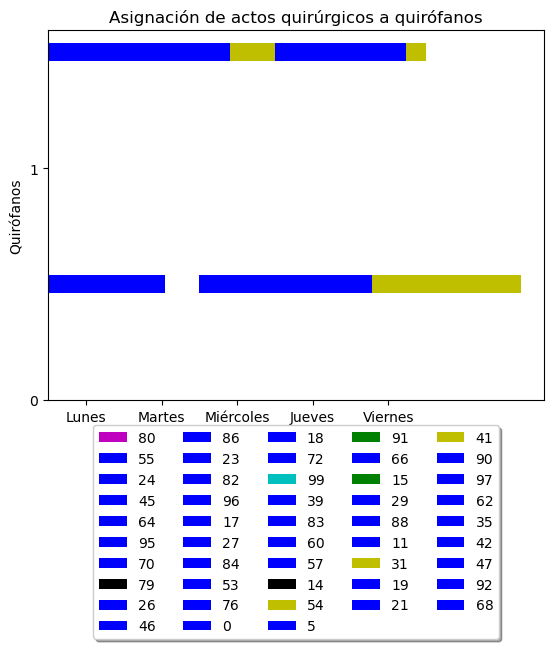

In [43]:
# Representamos gráficamente la asignación de actos quirúrgicos a quirófanos
# Función que representa gráficamente la asignación de actos quirúrgicos a quirófanos
def representacionAsignacion(asignacion):
    # Creamos una lista de colores
    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    # Creamos una lista de días
    dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes']
    # Creamos una lista de quirófanos a partir de la primera dimensión de la asignación
    quirofanos = [i for i in range(len(asignacion))]
    # Creamos un diccionario de días a partir de la segunda dimensión de la asignación
    dias_dict = {i: dias[i] for i in range(len(asignacion[0]))}
    # Accedemos a cada quirófano
    for i in range(len(asignacion)):
        # Accedemos a cada día
        for j in range(len(asignacion[i])):
            # Accedemos a cada acto quirúrgico
            for acto in asignacion[i][j].getActos():
                # Representamos el acto quirúrgico
                plt.barh((i+1)*10, acto.getDuracion(), left=j*100, color=colores[acto.getPrioridad()%7], label=acto.getId())
    # Añadimos la leyenda
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    # Añadimos el título
    plt.title('Asignación de actos quirúrgicos a quirófanos')
    # Añadimos el nombre de los ejes
    plt.xlabel('Días')
    plt.ylabel('Quirófanos')
    # Añadimos los ticks de los ejes
    plt.xticks([i*100+50 for i in range(len(dias))], dias)
    plt.yticks([i*10+5 for i in range(len(quirofanos))], quirofanos)
    # Mostramos la gráfica
    plt.show()

representacionAsignacion(asignacion_LPTEDD)